In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Logs all messages except INFO and WARNING.
import logging
logging.basicConfig(level="ERROR") #set log level to error to avoid nonnecessary message
np.set_printoptions(suppress=True)
import tensorflow as tf


In [2]:
import tensorflow_datasets as tfds


import tensorflow_text
from pprint import pprint
from IPython.display import clear_output


In [3]:
import sys

print('PYTHON:',sys.version)
print("TF VERSION:",tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow 'IS' using the GPU")
else:
  print("TensorFlow 'IS NOT' using the GPU")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.platform import build_info as tf_build_info
print("CUDA Version:", tf_build_info.build_info['cuda_version'])
print("cuDNN Version:", tf_build_info.build_info['cudnn_version'])

PYTHON: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
TF VERSION: 2.13.1
TensorFlow 'IS' using the GPU
Num GPUs Available:  1
CUDA Version: 11.8
cuDNN Version: 8


In [4]:
tf_build_info.build_info

OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [5]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [6]:
config = tfds.translate.wmt.WmtConfig(
    version=tfds.core.Version('0.0.7', experiments={tfds.core.Experiment.DUMMY: False}),
    language_pair=("zh", "en"),
    subsets={
        tfds.Split.TRAIN: ["newscommentary_v14"]
    }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
#clear_output()

In [7]:
train_examples, val_examples, test_examples = builder.as_dataset(split=['train[:80%]','train[80%:90%]', 'train[90%:]'])
print(train_examples)

<_PrefetchDataset element_spec={'en': TensorSpec(shape=(), dtype=tf.string, name=None), 'zh': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [8]:
sample_examples = []
num_samples = 5
c = 1
for item in train_examples.take(num_samples).as_numpy_iterator():
    print(item.get('en').decode())
    print(item.get('zh').decode())
    c += 1
    sample_examples.append((item.get('zh').decode(), item.get('en').decode()))

这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
The fear is real and visceral, and politicians ignore it at their peril.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。
In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。
Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
在这方面，关键在于认识到“城市村落”和农村村落之间的根本区别。
In this sense, it is critical to recognize the fundamental difference between “urban villages” and their rural counterparts.
法国担任轮值主席国期间尼古拉·萨科奇统一的欧洲声音可能让人耳目一新，但这种声音却只持续了短短六个月，而且付出了让其他欧洲国家在面对“高卢人的骄傲”时民族主义情感进一步被激发的代价。
A strong European voice, such as Nicolas Sarkozy’s during the French presidency of the EU, may make a difference, but only for six months, and at the cost of reinforcing other European countries’ nationalist feelings in reaction to the expression of “Gallic pride.”


In [9]:
%%time
try:
    subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
    print(f"載入已建立的字典： {en_vocab_file}")
except:
    print("沒有已建立的字典，從頭建立。")
    subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (item.get('zh').decode() for item in train_examples.as_numpy_iterator()),
        target_vocab_size=2**13 
    ) # 有需要可以調整字典大小
    # 將字典檔案存下以方便下次 warmstart
    subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 100 個 subwords：{subword_encoder_en.subwords[:100]}")
print()

載入已建立的字典： nmt/en_vocab
字典大小：8271
前 100 個 subwords：[', ', 'the_', 'to_', 'of_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_', '’', 'for_', ' – ', 'on_', 'be_', 'The_', 'as_', 'are_', 'ing_', 'with_', 'by_', 'it_', 'has_', 'not_', 'ed_', 'have_', 'will_', 'd_', 'from_', 'its_', 'their_', 'an_', 'more_', 'or_', ' “', 'would_', 'was_', 'at_', 'they_', 'this_', 'But_', 'which_', 'e_', 'In_', 'than_', 'US_', 'can_', 'but_', ' (', 'been_', 'y_', 'economic_', 'ly_', 'his_', 't_', '” ', 'also_', '% ', 'only_', 'new_', 'ed', 'should_', 'ng_', 'could_', 'we_', 'global_', 'one_', 'countries_', 'other_', 'all_', 'such_', 'about_', 'who_', 'political_', 'most_', ': ', 'no_', 'even_', '; ', 'if_', 'were_', 'China', 'many_', 'government_', 'ing', 'es_', 'European_', 'financial_', 'This_', 'when_', '’ ', 'ly', 'some_', 'must_', 'now_', 'he_', 'these_', 'there_', 'into_', 'al_']

CPU times: user 23.4 ms, sys: 2.7 ms, total: 26.1 ms
Wall time: 25.3 ms


In [10]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
print(indices)

[3106, 8047, 9, 3093, 3050, 1252, 8061]


In [11]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
    subword = subword_encoder_en.decode([idx])
    print('{0:5}{1:6}'.format(idx, ' ' * 5 + "'" + subword + "'"))

Index     Subword
---------------
 3106     'Taiwan'
 8047     ' '
    9     'is '
 3093     'bea'
 3050     'uti'
 1252     'ful'
 8061     '.'


In [12]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Taiwan is beautiful.', 'Taiwan is beautiful.')


In [13]:
%%time
# 為中文建立字典
try:
    subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
    print(f"載入已建立的字典： {zh_vocab_file}")
except Exception:
    print('沒有已建立的字典，從頭建立。')
    subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (item.get('en').decode() for item in train_examples.as_numpy_iterator()),
        target_vocab_size=2**13,
        max_subword_length=1  # 每一個中文字就是字典裡的一個單位
    )
    # 保存
    subword_encoder_zh.save_to_file(zh_vocab_file)
    
print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 100 個 subwords：{subword_encoder_zh.subwords[:100]}")
print()


載入已建立的字典： nmt/zh_vocab
字典大小：4800
前 100 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这', '有', '人', '—', '了', '为', '中', '政', '大', '以', '们', '能', '会', '经', '对', '年', '可', '要', '来', '而', '个', '美', '他', '家', '但', '其', '、', '行', '于', '上', '到', '成', '也', '地', '欧', '如', '出', '力', '发', '将', '多', '主', '实', '所', '济', '时', '法', '民', '利', '现', '全', '方', '（', '）', '自', '资', '些', '生', '斯', '我', '最', '更', '因', '就', '动', '性', '过', '者', '此', '之', '得', '本', '重', '并', '长', '“', '”', '定', '制', '新', '化', '洲', '机', '与', '业', '加', '用', '同', '前', '度', '作']

CPU times: user 9.08 ms, sys: 5.73 ms, total: 14.8 ms
Wall time: 14.4 ms


In [14]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
[10, 149, 572, 1245, 6, 385, 52, 29, 192, 5, 1, 3, 4576, 949, 438, 124, 1, 17, 123, 33, 20, 98, 1109, 1227, 856, 3]


In [15]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[16, 936, 11, 6, 1591, 746, 8, 223, 2229, 2435, 245, 4, 87, 1270, 8061]
[44, 201, 176, 1, 870, 202, 232, 601, 44, 91, 17, 123, 101, 37, 7, 279, 82, 18, 211, 273, 3]


In [16]:
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

In [17]:
en_t = next(iter(train_examples)).get('zh')
zh_t = next(iter(train_examples)).get('en')
print(en_t)
print(zh_t)
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
英文 BOS 的 index： 8271
英文 EOS 的 index： 8272
中文 BOS 的 index： 4800
中文 EOS 的 index： 4801

輸入為 2 個 Tensors：
(<tf.Tensor: shape=(), dtype=string, numpy=b'The fear is real and visceral, and politicians ignore it at their peril.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5

In [18]:
def tf_encode(item):
    # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
    # 要到 `tf.py_funtion` 裡頭才是
    # 另外因為索引都是整數，所以使用 `tf.int64`
    en_t = item.get('zh')
    zh_t = item.get('en')
    return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor(
[8271   16 1150    9  249    5 1422 2155  191    1    5 1040 5246   22
   38   31 3529 8123 8061 8272], shape=(20,), dtype=int64)
tf.Tensor(
[4800   10  149  572 1245    6  385   52   29  192    5    1    3 4576
  949  438  124    1   17  123   33   20   98 1109 1227  856    3 4801], shape=(28,), dtype=int64)


In [19]:
MAX_LENGTH = 60

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

In [20]:
# 因為我們數據量小可以這樣 count
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

所有英文與中文序列長度都不超過 60 個 tokens
訓練資料集裡總共有 196859 筆數據


In [21]:
BATCH_SIZE = 128
BUFFER_SIZE = 15000


# 訓練集
train_dataset = (train_examples # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 MAX_LENGTH
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, 
                               padded_shapes=([-1], [-1]) # padded_shapes=([MAX_LENGTH], [MAX_LENGTH]
                              ) # 將 batch 裡的序列都 pad 到一樣長度
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速

# 驗證集
val_dataset = (val_examples
                 .map(tf_encode)
                 .filter(filter_max_length)
                 .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1])))

# 測試集
test_dataset = (test_examples
                 .map(tf_encode)
                 .filter(filter_max_length)
                 .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1])))


In [22]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8271  316  238 ...    0    0    0]
 [8271   89 6273 ...    0    0    0]
 [8271  157   39 ...    0    0    0]
 ...
 [8271 8084  472 ...    0    0    0]
 [8271  123  302 ...    0    0    0]
 [8271  244    8 ...    0    0    0]], shape=(128, 59), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4800  161   38 ...    0    0    0]
 [4800   10  700 ...    3 4801    0]
 [4800   45  116 ...    0    0    0]
 ...
 [4800  233   68 ...    0    0    0]
 [4800   29  125 ...    0    0    0]
 [4800    5  237 ...    0    0    0]], shape=(128, 60), dtype=int64)


In [23]:
demo_examples = {'zh': ['It is important.', 'The numbers speak for themselves.'], 
                 'en': ['这很重要。', '数字证明了一切。']}
pprint(demo_examples)

{'en': ['这很重要。', '数字证明了一切。'],
 'zh': ['It is important.', 'The numbers speak for themselves.']}


In [24]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices(
    demo_examples
)

demo_dataset = demo_examples.map(tf_encode).padded_batch(batch_size, padded_shapes=([-1], [-1]))

inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8271  103    9  984 8061 8272    0    0]
 [8271   16 3991 5315   12 2337 8061 8272]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4800   10  237   82   27    3 4801    0    0    0]
 [4800  166  490  406  193   14    7  552    3 4801]], shape=(2, 10), dtype=int64)


In [25]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
 array([[[ 0.00731532, -0.03201591,  0.03905975,  0.04797098],
         [-0.0366235 , -0.00375736,  0.04569234,  0.01163111],
         [ 0.04726856, -0.03191681, -0.02939991, -0.03378211],
         [-0.03652076,  0.02725298, -0.02106973, -0.02914258],
         [ 0.02684525,  0.01733326,  0.02097073, -0.02208864],
         [-0.01084427,  0.00910794, -0.01156554, -0.0071543 ],
         [-0.01613613,  0.03566057, -0.04537519, -0.01144149],
         [-0.01613613,  0.03566057, -0.04537519, -0.01144149]],
 
        [[ 0.00731532, -0.03201591,  0.03905975,  0.04797098],
         [ 0.02446325, -0.02298675,  0.02559366,  0.02224514],
         [-0.02628883,  0.00246524, -0.00510386, -0.01277151],
         [ 0.04829365,  0.02565838, -0.00990652, -0.04993993],
         [ 0.03326495, -0.04427944, -0.04906414, -0.0019776 ],
         [-0.02530547,  0.01936592, -0.0457485 ,  0.01216144],
         [ 0.02684525,  0.01733326,  0.02097073, -0.02208864],


In [26]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[-0.01079718  0.03529638 -0.02600555  0.01229019]
 [-0.01079718  0.03529638 -0.02600555  0.01229019]
 [-0.01079718  0.03529638 -0.02600555  0.01229019]], shape=(3, 4), dtype=float32)


In [27]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

<tf.Tensor: shape=(2, 1, 1, 8), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [28]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8271  103    9  984 8061 8272    0    0]
 [8271   16 3991 5315   12 2337 8061 8272]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [29]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [31]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

output: tf.Tensor(
[[[0.37521374 0.3749948  0.37468296 0.49995857]
  [0.3751519  0.37513947 0.37490532 0.4999439 ]
  [0.3749082  0.37477073 0.37498447 0.50010145]
  [0.37485403 0.37511486 0.37524205 0.5000103 ]
  [0.37505832 0.37492564 0.37506366 0.4999762 ]
  [0.3749389  0.37503454 0.37508094 0.5000063 ]
  [0.37479633 0.37506634 0.3752526  0.500013  ]
  [0.37479633 0.37506634 0.3752526  0.500013  ]]

 [[0.6251191  0.24986133 0.6251139  0.37517267]
  [0.6250367  0.24988995 0.62504834 0.37506616]
  [0.62500453 0.25003296 0.6249777  0.37497914]
  [0.62485266 0.24994776 0.6248964  0.37471318]
  [0.6248511  0.2502895  0.6248839  0.3752247 ]
  [0.62498736 0.25025123 0.62499374 0.37513322]
  [0.6249726  0.24983004 0.62498945 0.37478358]
  [0.62498736 0.25005344 0.6249829  0.3749851 ]]], shape=(2, 8, 4), dtype=float32)
--------------------
attention_weights: tf.Tensor(
[[[0.12535845 0.12518868 0.12496377 0.1248414  0.1250139  0.12497848
   0.12482765 0.12482765]
  [0.12515077 0.12523736 0.124

In [32]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[ 0.00731532 -0.03201591  0.03905975  0.04797098]
  [-0.0366235  -0.00375736  0.04569234  0.01163111]
  [ 0.04726856 -0.03191681 -0.02939991 -0.03378211]
  [-0.03652076  0.02725298 -0.02106973 -0.02914258]
  [ 0.02684525  0.01733326  0.02097073 -0.02208864]
  [-0.01084427  0.00910794 -0.01156554 -0.0071543 ]
  [-0.01613613  0.03566057 -0.04537519 -0.01144149]
  [-0.01613613  0.03566057 -0.04537519 -0.01144149]]

 [[ 0.00731532 -0.03201591  0.03905975  0.04797098]
  [ 0.02446325 -0.02298675  0.02559366  0.02224514]
  [-0.02628883  0.00246524 -0.00510386 -0.01277151]
  [ 0.04829365  0.02565838 -0.00990652 -0.04993993]
  [ 0.03326495 -0.04427944 -0.04906414 -0.0019776 ]
  [-0.02530547  0.01936592 -0.0457485   0.01216144]
  [ 0.02684525  0.01733326  0.02097073 -0.02208864]
  [-0.01084427  0.00910794 -0.01156554 -0.0071543 ]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[ 0.00731532 -0.03201591]
   [-0.0366235  -0.00375736]
   [ 0.04726856 -0.03191681]
   [-0.0365

In [33]:
# 實作一個執行多頭注意力機制的 keras layer
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  # 這跟我們前面看過的函式有 87% 相似
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
    # 輸出會多一個 head 維度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [34]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

d_model: 4
num_heads: 2

q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.00342836 -0.00019767 -0.00000927 -0.00013037]
  [ 0.00343046 -0.00019972 -0.00000771 -0.00012643]
  [ 0.00342361 -0.00021318  0.00000605 -0.00011791]
  [ 0.00342252 -0.00021149  0.00000392 -0.00011704]
  [ 0.00342846 -0.00020443 -0.0000041  -0.0001251 ]
  [ 0.00342389 -0.00020905  0.00000149 -0.0001207 ]
  [ 0.00341975 -0.00021435  0.00000606 -0.00011735]
  [ 0.00341975 -0.00021435  0.00000606 -0.00011735]]

 [[-0.00738585  0.00206022  0.00127354 -0.00107395]
  [-0.00738504  0.00205962  0.00127429 -0.00107338]
  [-0.00739022  0.00205914  0.00127804 -0.00106889]
  [-0.00738507  0.00205778  0.00127595 -0.00106958]
  [-0.00738399  0.00206299  0.00127409 -0.00107103]
  [-0.00739028  0.0020585   0.00127783 -0.00107056]
  [-0.00738511  0.00205735  0.00127581 -0.0010707 ]
  [-0.00739026  0.002

In [35]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [36]:
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [37]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [38]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8271  103    9  984 8061 8272    0    0]
 [8271   16 3991 5315   12 2337 8061 8272]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[ 0.00731532 -0.03201591  0.03905975  0.04797098]
  [-0.0366235  -0.00375736  0.04569234  0.01163111]
  [ 0.04726856 -0.03191681 -0.02939991 -0.03378211]
  [-0.03652076  0.02725298 -0.02106973 -0.02914258]
  [ 0.02684525  0.01733326  0.02097073 -0.02208864]
  [-0.01084427  0.00910794 -0.01156554 -0.0071543 ]
  [-0.01613613  0.03566057 -0.04537519 -0.01144149]
  [-0.01613613  0.03566057 -0.04537519 -0.01144149]]

 [[ 0.00731532 -0.03201591  0.03905975  0.04797098]
  [ 0.02446325 -0.02298675  0.02559366  0.02224514]
  [-0.02628883  0.00246524 -0.00510386 -0.01277151]
  [ 0.04829365  0.02565838 -0.00990652 -0.04993993]
  [ 0.03326495 -0.04427944 -0.04906414 -0.0019776 ]
  [

In [39]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

In [40]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.03018809  0.02772966  0.033124    0.03716457]
  [ 0.01822342  0.04289198 -0.02956367  0.04136899]
  [ 0.02675866  0.00087608 -0.02886534  0.01634819]
  [-0.01838303  0.03234065 -0.001836   -0.03319644]
  [ 0.00582308  0.01177128  0.00924579  0.03551194]
  [-0.00516673  0.00119359 -0.00121345 -0.04757861]
  [-0.03111359 -0.00290207  0.02456255  0.04642658]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]]

 [[ 0.03018809  0.02772966  0.033124    0.03716457]
  [-0.02203496  0.01723207 -0.00108542 -0.04882553]
  [-0.02799409 -0.02210044 -0.03539402 -0.01938089]
  [-0.0165637  -0.03534932  0.00263242 -0.00294723]
  [-0.04938749  0.03874001  0.00227449 -0.00210779]
  [ 0.04323832 -0.02986794  0.010677   -0.00137632]
  [ 0.03407819  0.02498594 -0.04496486 -0.01946827]
  [ 0.00234399 -0.0047228   0.04491762  0.04980611]
  [-0.00516673  0.00119359 -0.00121345 -0.

In [41]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

tar: tf.Tensor(
[[4800   10  237   82   27    3 4801    0    0    0]
 [4800  166  490  406  193   14    7  552    3 4801]], shape=(2, 10), dtype=int64)
--------------------
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
--------------------
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0.

In [42]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[ 0.03018809  0.02772966  0.033124    0.03716457]
  [ 0.01822342  0.04289198 -0.02956367  0.04136899]
  [ 0.02675866  0.00087608 -0.02886534  0.01634819]
  [-0.01838303  0.03234065 -0.001836   -0.03319644]
  [ 0.00582308  0.01177128  0.00924579  0.03551194]
  [-0.00516673  0.00119359 -0.00121345 -0.04757861]
  [-0.03111359 -0.00290207  0.02456255  0.04642658]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]
  [-0.01079718  0.03529638 -0.02600555  0.01229019]]

 [[ 0.03018809  0.02772966  0.033124    0.03716457]
  [-0.02203496  0.01723207 -0.00108542 -0.04882553]
  [-0.02799409 -0.02210044 -0.03539402 -0.01938089]
  [-0.0165637  -0.03534932  0.00263242 -0.00294723]
  [-0.04938749  0.03874001  0.00227449 -0.00210779]
  [ 0.04323832 -0.02986794  0.010677   -0.00137632]
  [ 0.03407819  0.02498594 -0.04496486 -0.01946827]
  [ 0.00234399 -0.0047228   0.04491762  0.04980611]
  [-0.00516673  0.00119359 -0.00121345 -0.

In [43]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

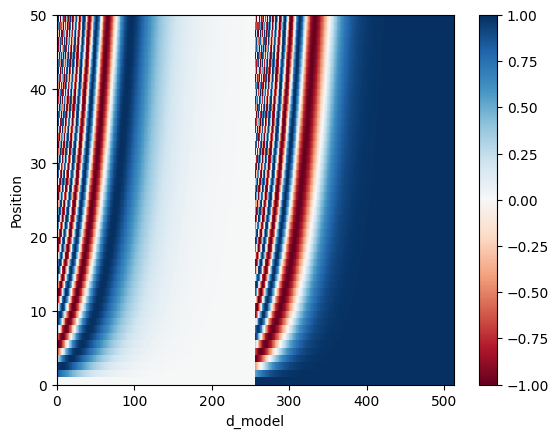

In [44]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [45]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - dff: FFN 中間層的維度
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 

In [46]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8271  103    9  984 8061 8272    0    0]
 [8271   16 3991 5315   12 2337 8061 8272]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-1.4648131  -0.11320687  1.3351003   0.24291962]
  [-0.9255852  -0.91557753  1.4728795   0.3682833 ]
  [-0.7573248   1.62052    -0.89409935  0.03090426]
  [-1.1441948   0.85485697 -0.83466107  1.1239989 ]
  [-1.6029891   0.27404878  0.17852905  1.1504114 ]
  [-1.6315976  -0.00368994  0.79779077  0.83749694]
  [-1.5093904  -0.10300962  1.2596364   0.35276347]
  [-1.073409   -0.39686096  1.6321981  -0.16192819]]

 [[-1.4843533  -0.09397036  1.3098862   0.2684374 ]
  [-0.9936253  -0.62149477  1.620623   -0.00550294]
  [-0.5442625   1.6630844  -0.9544053  -0.16441658]
  [-1.2208532   0.7017982  -0.7105969   1.2296519 ]
  [-1.5805819   0.25125846  0.13784358  1.19148   ]
  [-1.6469891   0.05610324  0.8924396   0.69844615]
  [-1.5556922   0.00139032  1.2083639   0.34593803]
  [-1.3143182  -0.4373181   1.3988868   0.3527

In [47]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [48]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4800   10  237   82   27    3 4801    0    0    0]
 [4800  166  490  406  193   14    7  552    3 4801]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-1.4648131  

In [49]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [50]:
# 超參數
num_layers = 1
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `comined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4800   10  237   82   27    3 4801    0    0    0]
 [4800  166  490  406  193   14    7  552    3 4801]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4800   10  237   82   27    3 4801    0    0]
 [4800  166  490  406  193   14    7  552    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  237   82   27    3 4801    0    0    0]
 [ 166  490  406  193   14    7  552    3 4801]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.01066641 -0.04772566  0.02575547 ... -0.02138724  0.04634662
    0.06482837]
  [-0.02164257 -0.0640014   0.03100749 ... -0.02969712  0.00975495
    0.0386771 ]
  [-0.03138593 -0.06042983  0.0261397  ... -0.03241279  0.00383915
    0.03768303]
  ...
  [-0.01551073 -0.07256271  0.03379937 ... -0.03785068  0.03570718
    0.07323292]
  [-0.02027709 -0.06704856  0.03275209 ... -0.03097381  0.01355176
    0.04348082]
  [-0.03019787 -0.0598952   0.02630353 ... -0.031

In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# 假設我們要解的是一個 binary classifcation， 0 跟 1 個代表一個 label
real = tf.constant([1, 1, 0], shape=(1, 3), dtype=tf.float32)
pred = tf.constant([[0, 1], [0, 1], [0, 1]], dtype=tf.float32)
loss_object(real, pred)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.31326175, 0.31326175, 1.3132617 ], dtype=float32)>

In [52]:
print("predictions:", predictions)
print("-" * 20)
print(tf.reduce_sum(predictions, axis=-1))

predictions: tf.Tensor(
[[[ 0.01066641 -0.04772566  0.02575547 ... -0.02138724  0.04634662
    0.06482837]
  [-0.02164257 -0.0640014   0.03100749 ... -0.02969712  0.00975495
    0.0386771 ]
  [-0.03138593 -0.06042983  0.0261397  ... -0.03241279  0.00383915
    0.03768303]
  ...
  [-0.01551073 -0.07256271  0.03379937 ... -0.03785068  0.03570718
    0.07323292]
  [-0.02027709 -0.06704856  0.03275209 ... -0.03097381  0.01355176
    0.04348082]
  [-0.03019787 -0.0598952   0.02630353 ... -0.03151277  0.00353196
    0.03622226]]

 [[ 0.01031843 -0.05561943  0.03053877 ... -0.0235363   0.04719391
    0.06708886]
  [-0.02168782 -0.06118323  0.02973994 ... -0.02802106  0.00688541
    0.03412448]
  [-0.03161611 -0.05892419  0.02537543 ... -0.03166905  0.00232061
    0.03549113]
  ...
  [-0.01764281 -0.07474266  0.03549539 ... -0.03734677  0.03006244
    0.06669401]
  [-0.0203561  -0.06434516  0.03158106 ... -0.02927078  0.01050024
    0.03869319]
  [-0.02920166 -0.05968479  0.02654834 ... -0.030

In [53]:
def loss_function(real, pred):
  # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # 照樣計算所有位置的 cross entropy 但不加總
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  # 只計算非 <pad> 位置的損失 
  
  return tf.reduce_mean(loss_)

In [54]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [55]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8273
target_vocab_size: 4802


In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  
# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

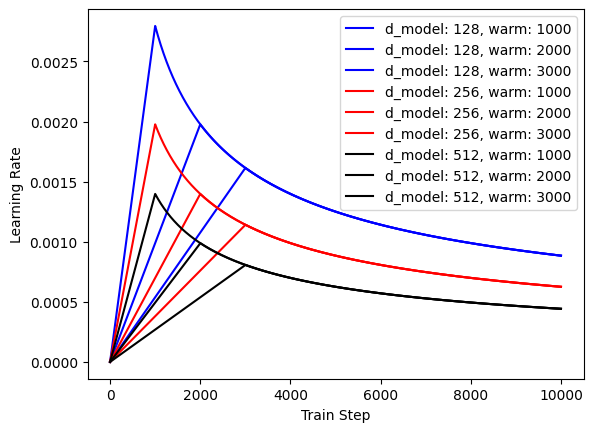

In [57]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
  schedules += [CustomSchedule(d, s) for s in warmup_steps]
  labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
  plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [58]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8273
target_vocab_size: 4802
dropout_rate: 0.1




In [59]:
# 為 Transformer 的 Encoder / Decoder 準備遮罩
def create_masks(inp, tar):
  # 英文句子的 padding mask，要交給 Encoder layer 自注意力機制用的
  enc_padding_mask = create_padding_mask(inp)
  
  # 同樣也是英文句子的 padding mask，但是是要交給 Decoder layer 的 MHA 2 
  # 關注 Encoder 輸出序列用的
  dec_padding_mask = create_padding_mask(inp)
  
  # Decoder layer 的 MHA1 在做自注意力機制用的
  # `combined_mask` 是中文句子的 padding mask 跟 look ahead mask 的疊加
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [60]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
  # 前面說過的，用去尾的原始序列去預測下一個字的序列
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 建立 3 個遮罩
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
  with tf.GradientTape() as tape:
    # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
    loss = loss_function(tar_real, predictions)

  # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [61]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff"
checkpoint_path = os.path.join(checkpoint_dir, run_id)
print("checkpoint_path=",checkpoint_path)
log_dir = os.path.join(log_dir, run_id)
print("log_dir=",log_dir)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  
  # 用來確認之前訓練多少 epochs 了
  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
  last_epoch = 0
  print("沒找到 checkpoint，從頭訓練。")

checkpoint_path= nmt/checkpoints/4layers_128d_8heads_512dff
log_dir= nmt/logs/4layers_128d_8heads_512dff
已讀取最新的 checkpoint，模型已訓練 30 epochs。


In [62]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")

# 用來寫資訊到 TensorBoard，非必要但十分推薦
summary_writer = tf.summary.create_file_writer(log_dir)

# 比對設定的 `EPOCHS` 以及已訓練的 `last_epoch` 來決定還要訓練多少 epochs
for epoch in range(last_epoch, EPOCHS):
  print(f"剩餘 epochs：{max(0, EPOCHS - epoch )}")
  start = time.time()
  
  # 重置紀錄 TensorBoard 的 metrics
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
  for (step_idx, (inp, tar)) in enumerate(train_dataset):
    
    # 每次 step 就是將數據丟入 Transformer，讓它生預測結果並計算梯度最小化 loss
    train_step(inp, tar)  

  # 每個 epoch 完成就存一次檔    
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # 將 loss 以及 accuracy 寫到 TensorBoard 上
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
  print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


此超參數組合的 Transformer 已經訓練 30 epochs。


In [63]:
%reload_ext tensorboard
%tensorboard --logdir nmt/logs/4layers_128d_8heads_512dff

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/program.py", line 292, in _run_serve_subcommand
    server = sel

In [64]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
  
  # 準備英文句子前後會加上的 <start>, <end>
  start_token = [subword_encoder_en.vocab_size]
  end_token = [subword_encoder_en.vocab_size + 1]
  
  # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
  # 並在前後加上 BOS / EOS
  inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
  # 是一個只包含一個中文 <start> token 的序列
  decoder_input = [subword_encoder_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度
  
  # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
  for i in range(MAX_LENGTH):
    # 每多一個生成的字就得產生新的遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

    # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
    if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights
    
    #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
    # 下個中文字的時候關注到最新的 `predicted_id`
    output = tf.concat([output, predicted_id], axis=-1)

  # 將 batch 的維度去掉後回傳預測的中文索引序列
  return tf.squeeze(output, axis=0), attention_weights

In [65]:
# 要被翻譯的英文句子
sentence = "Do you want some music?"

# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: Do you want some music?
--------------------
predicted_seq: tf.Tensor([4800  625  300   27    7   66 1170  851  905  348], shape=(10,), dtype=int32)
--------------------
predicted_sentence: 你想要一些音乐吗？


In [66]:
!pip install opencc-python-reimplemented

Defaulting to user installation because normal site-packages is not writeable


In [67]:
import opencc

In [68]:
from opencc import OpenCC
cc = OpenCC('s2tw')

In [80]:
# 要被翻譯的英文句子
sentence = "Do yo have enough money for study abroad?"

# 取得預測的中文索引序列
predicted_seq, _ = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", cc.convert(predicted_sentence))

sentence: Do yo have enough money for study abroad?
--------------------
predicted_seq: tf.Tensor(
[4800   10    6  443   11  431  320    1   65  120   21  320    5  499
  133  459  462  348], shape=(18,), dtype=int32)
--------------------
predicted_sentence: 這是否有足夠的資金能夠在海外研究？
